<a href="https://colab.research.google.com/github/raulbenitez/AMRITA_UPC/blob/main/classify_blobs_types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage.util import random_noise

L = 256 
N = 2000 # number of images

I = np.zeros((L,L,N))
IG = np.zeros((L,L,N))
IL = np.zeros((L,L,N))

v = np.random.randint(2, size=N)

for k in range(N):
  if v[k] == 0:
    I_aux = data.binary_blobs(length=L, blob_size_fraction=0.3,volume_fraction=0.3)
  else:
    I_aux = data.binary_blobs(length=L, blob_size_fraction=0.3,volume_fraction=0.3)

  I[:,:,k] = I_aux
  IG[:,:,k] = random_noise(I_aux,clip=True,mode='localvar')

  label_image, nregions = measure.label(I[:,:,k],return_num=True)
  IL[:,:,k] = label_image
  props_aux = measure.regionprops_table(label_image,properties=['label','area','eccentricity','extent'])

  if k == 0:
    df = pd.DataFrame(props_aux)
  else: 
    df = df.append(pd.DataFrame(props_aux), ignore_index=True)

  df_aux = pd.DataFrame(props_aux)
  a_max = max(df_aux['area'].values)


  #print('Image number {}, number of regions {}, area of largest region {}, class {}'.format(k,nregions,a_max,v[k]))

In [113]:
v

array([1, 0, 0, ..., 1, 1, 1])

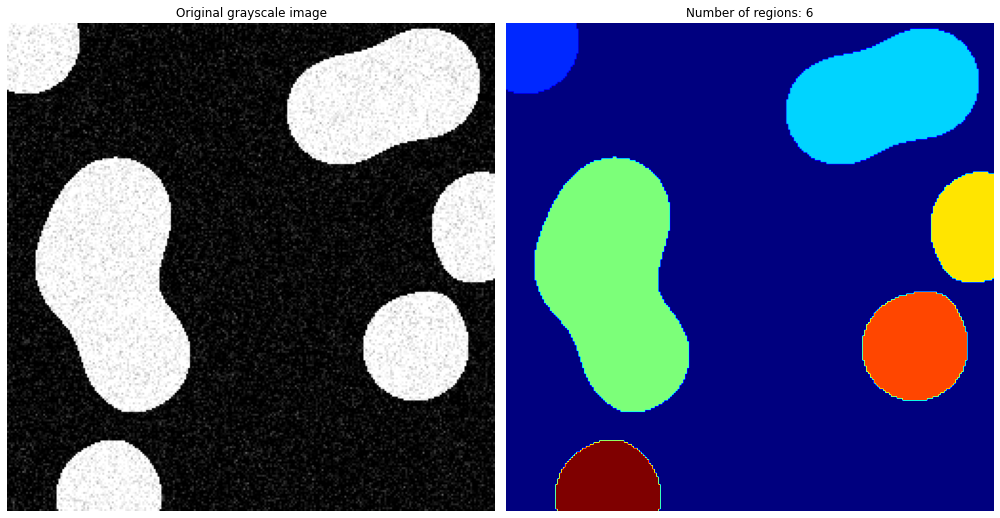

In [114]:
# Get some figures:
fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(IG[:,:,-1],cmap=plt.cm.gray)
ax[0].set_title('Original grayscale image') 
ax[1].imshow(IL[:,:,-1],cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

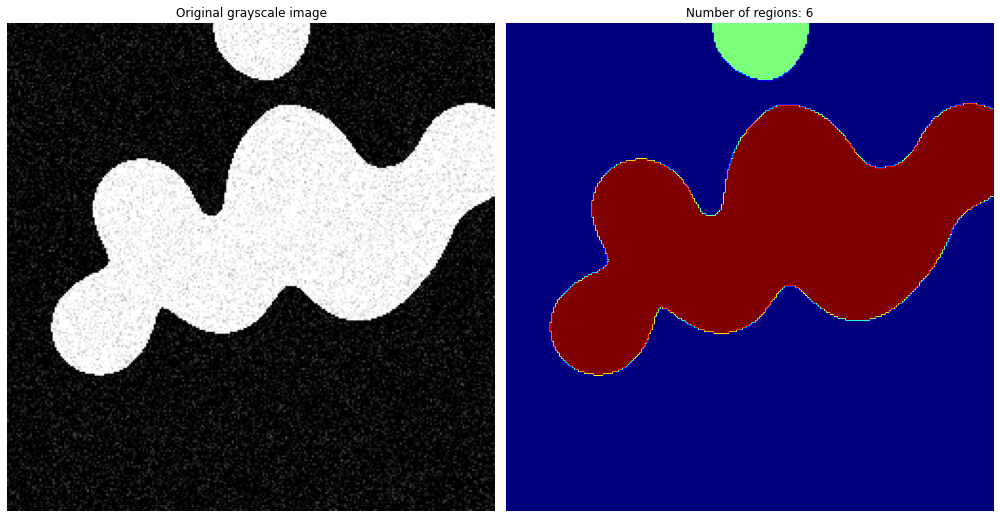

In [115]:
# Get some figures:
fig, axes = plt.subplots(1,2,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(IG[:,:,1],cmap=plt.cm.gray)
ax[0].set_title('Original grayscale image') 
ax[1].imshow(IL[:,:,1],cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title

ax[0].set_axis_off()
ax[1].set_axis_off()
plt.tight_layout()
plt.show()

#2. Train a DL model

To classify images according to the class (class=0 if there are no large blobs and class = 1 if the image contains a large blob)


Shape data and split in training and test subsets:

In [116]:
X = np.expand_dims(IG, -1)
X = np.transpose(X, (2,1,0,3))
X.shape
y=v

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

When data is uint8, scale and convert to float

In [118]:
#X_train = X_train / 255.
#X_test = X_test / 255.
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')

In [119]:
X_train.shape

(1340, 256, 256, 1)

In [120]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Model / data parameters
num_classes = 2
input_shape = (L, L, 1)

# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

# Train model:
batch_size =64
epochs = 5

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 features (Flatten)          (None, 246016)            0         
                                                                 
 dropout_2 (Dropout)         (None, 246016)           

In [121]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['normal', 'pathological']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 0.7399720549583435
Test accuracy: 0.5121212005615234
              precision    recall  f1-score   support

      normal       0.51      0.74      0.60       331
pathological       0.52      0.28      0.37       329

    accuracy                           0.51       660
   macro avg       0.51      0.51      0.48       660
weighted avg       0.51      0.51      0.49       660



In [122]:
y_test_pred = np.argmax(model.predict(X_test),axis=1)

In [123]:
print(y_test_pred)

[0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0
 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1
 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 1 